In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import root
from scipy.optimize import minimize_scalar

# Données du problème

In [25]:
# === Conditions initiale === #
# x0 :  biomasse initiale
# y0 : concentration polluant dans le réacteur
# z0 : concentration dans le lac
# Q : débit entrée/sortie d'eau entre lac et bioréacteur
# mu : loi de croissance de la biomasse dans le bioréacteur
# epsilon : rapport des volumes du lac et du bioréacteur

# Définition des fonctions utiles

In [26]:
# === Système différentiel ===
def system(t, state):
    x, y, z = state
    dx = mu * x * y - Q * x
    dy = -mu * x * y + Q * (z - y)
    dz = epsilon * Q * (y - z)
    return np.array([dx, dy, dz])
    
# === Implémentation des différentes méthodes ===
#RK4
def rk4(f, y0, t):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], y[i])
        k2 = f(t[i] + h/2, y[i] + h/2 * k1)
        k3 = f(t[i] + h/2, y[i] + h/2 * k2)
        k4 = f(t[i] + h, y[i] + h * k3)
        y[i+1] = y[i] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return y

#Euler Explicite
def euler_explicit(f, y0, t):
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(len(t) - 1):
        dt = t[i+1] - t[i]
        y[i+1] = y[i] + dt * f(t[i], y[i])
    return y

#Euler Implicite
def euler_implicit(f, y0, t, max_iter=10, tol=1e-6):
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(len(t) - 1):
        yn = y[i]
        yn1 = yn.copy()
        for _ in range(max_iter):
            yn1_new = yn + dt * f(t[i+1], yn1)
            if np.linalg.norm(yn1_new - yn1) < tol:
                break
            yn1 = yn1_new
        y[i+1] = yn1
    return y


#Renvoie le point critique pour le cas (0,z0,z0) 
def point_critique_eps_egale_zero_B(z0):
    return (0,z0, z0)
#Renvoie le point critique pour le cas (z0-Q/mu,Q/mu,z0) 
def point_critique_eps_egale_zero_A(mu, Q, z0):
    return (z0 - Q/mu, Q / mu, z0)

    
#Fonction Q(t)
def Q_func_log(t):
    Q0 = 2.0      # débit initial
    a = 1.0       # paramètre de décroissance
    return Q0 / (1 + a * np.log(1 + t))

#Renvoie la jacobienne
def jacobian(state):
    x, y, z = state
    return np.array([
        [mu * y - Q, mu * x, 0],
        [-mu * y, -mu * x - Q, Q],
        [0, epsilon * Q, -epsilon * Q]])
    
#Trace les portraits de phase de x , y ,z selon les cas stables, instables et limites 
def tracage_de_phase_stable_instable_limite(sol_stable,sol_limite,sol_instable,title=""):
    axes[0].plot(sol_stable[:, 0], sol_stable[:, 1], color='green', label='mu.z0 < Q')
    axes[0].plot(sol_limite[:, 0], sol_limite[:, 1], color='orange', label='mu.z0 = Q')
    axes[0].plot(sol_pas_stable[:, 0], sol_instable[:, 1], color='red', label='mu.z0 > Q')
    axes[0].scatter(0, pt_stable[1], color='green', marker='x', s=80)
    axes[0].scatter(0, pt_limite[1], color='orange', marker='x', s=80)
    axes[0].scatter(0, pt_pas_stable[1], color='red', marker='x', s=80)
    axes[0].annotate('', xy=(sol_stable[i_arrow+1, 0], sol_stable[i_arrow+1, 1]),
                     xytext=(sol_stable[i_arrow, 0], sol_stable[i_arrow, 1]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[0].annotate('', xy=(sol_pas_stable[i_arrow+1, 0], sol_pas_stable[i_arrow+1, 1]),
                     xytext=(sol_pas_stable[i_arrow, 0], sol_pas_stable[i_arrow, 1]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[0].annotate('', xy=(sol_limite[i_arrow+1, 0], sol_limite[i_arrow+1, 1]),
                     xytext=(sol_limite[i_arrow, 0], sol_limite[i_arrow, 1]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[0].set_xlabel('x (biomasse)')
    axes[0].set_ylabel('y (réacteur)')
    axes[0].set_title('y(x) - ' +title)
    axes[0].legend()
    # z vs x
    axes[1].plot(sol_stable[:, 0], sol_stable[:, 2], color='green', label='mu.z0 < Q')
    axes[1].plot(sol_limite[:, 0], sol_limite[:, 2], color='orange', label='mu.z0 = Q')
    axes[1].plot(sol_pas_stable[:, 0], sol_pas_stable[:, 2], color='red', label='mu.z0 > Q')
    axes[1].scatter(0, pt_stable[2], color='green', marker='x', s=80)
    axes[1].scatter(0, pt_limite[2], color='orange', marker='x', s=80)
    axes[1].scatter(0, pt_pas_stable[2], color='red', marker='x', s=80)
    axes[1].annotate('', xy=(sol_stable[i_arrow+1, 0], sol_stable[i_arrow+1, 2]),
                     xytext=(sol_stable[i_arrow, 0], sol_stable[i_arrow, 2]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[1].annotate('', xy=(sol_limite[i_arrow+1, 0], sol_limite[i_arrow+1, 2]),
                     xytext=(sol_limite[i_arrow, 0], sol_limite[i_arrow, 2]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[1].annotate('', xy=(sol_pas_stable[i_arrow+1, 0], sol_pas_stable[i_arrow+1, 2]),
                     xytext=(sol_pas_stable[i_arrow, 0], sol_pas_stable[i_arrow, 2]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[1].set_xlabel('x (biomasse)')
    axes[1].set_ylabel('z (lac)')
    axes[1].set_title('z(x) - '+title)
    axes[1].legend()
    # z vs y
    axes[2].plot(sol_stable[:, 1], sol_stable[:, 2], color='green', label='mu.z0 < Q')
    axes[2].plot(sol_limite[:, 1], sol_limite[:, 2], color='orange', label='mu.z0 = Q')
    axes[2].plot(sol_pas_stable[:, 1], sol_pas_stable[:, 2], color='red', label = 'mu.z0 > Q')
    axes[2].scatter(pt_stable[1], pt_stable[2], color='green', marker='x', s=80)
    axes[2].scatter(pt_limite[1], pt_limite[2], color='orange', marker='x', s=80)
    axes[2].scatter(pt_pas_stable[1], pt_pas_stable[2], color='red', marker='x', s=80)
    axes[2].annotate('', xy=(sol_stable[i_arrow+1, 1], sol_stable[i_arrow+1, 2]),
                     xytext=(sol_stable[i_arrow, 1], sol_stable[i_arrow, 2]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[2].annotate('', xy=(sol_limite[i_arrow+1, 1], sol_limite[i_arrow+1, 2]),
                     xytext=(sol_limite[i_arrow, 1], sol_limite[i_arrow, 2]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[2].annotate('', xy=(sol_pas_stable[i_arrow+1, 1], sol_pas_stable[i_arrow+1, 2]),
                     xytext=(sol_pas_stable[i_arrow, 1], sol_pas_stable[i_arrow, 2]),
                     arrowprops=dict(arrowstyle="->", color='black'))
    axes[2].set_xlabel('y (réacteur)')
    axes[2].set_ylabel('z (lac)')
    axes[2].set_title('z(y) - '+title)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

#Renvoie les trajectoires 3D des cas stables, instable,limites
def trajectoire_3D_stable_instable_limite(sol_stable,sol_limite,sol_instable,title=""):

    fig = plt.figure(figsize=(20, 14))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(sol_stable[:, 0], sol_stable[:, 1], sol_stable[:, 2], label='mu.z0 < Q', color='green')
    ax.plot(sol_limite[:, 0], sol_limite[:, 1], sol_limite[:, 2], label='mu.z0 = Q ', color='orange')
    ax.plot(sol_pas_stable[:, 0], sol_pas_stable[:, 1], sol_pas_stable[:, 2], label='mu.z0 > Q ', color='red')
    ax.scatter(*pt_stable, color='green', marker='x', s=80)
    ax.scatter(*pt_limite, color='orange', marker='x', s=80)
    ax.scatter(*pt_pas_stable, color='red', marker='x', s=80)
    
    # Flèche 3D sur cas limite
    dx = sol_limite[i_arrow+1, 0] - sol_limite[i_arrow, 0]
    dy = sol_limite[i_arrow+1, 1] - sol_limite[i_arrow, 1]
    dz = sol_limite[i_arrow+1, 2] - sol_limite[i_arrow, 2]
    ax.quiver(sol_limite[i_arrow, 0], sol_limite[i_arrow, 1], sol_limite[i_arrow, 2],
              dx, dy, dz, color='black', arrow_length_ratio=0.1)
    
    ax.set_xlabel('x (biomasse)')
    ax.set_ylabel('y (réacteur)')
    ax.set_zlabel('z (lac)')
    ax.set_title('Trajectoires 3D - '+title)
    ax.legend()
    plt.tight_layout()
    plt.show()


# Cas $\epsilon = 0$

# Point critique 1 : $A = \begin{pmatrix} 0 \\ z0 \\ z0 \end{pmatrix} $

## Cas 1 : $\mu z_0 < Q$ -> test stabilité

point critique =  [4.43102659e-07 4.99999956e+00 5.00000000e+00]


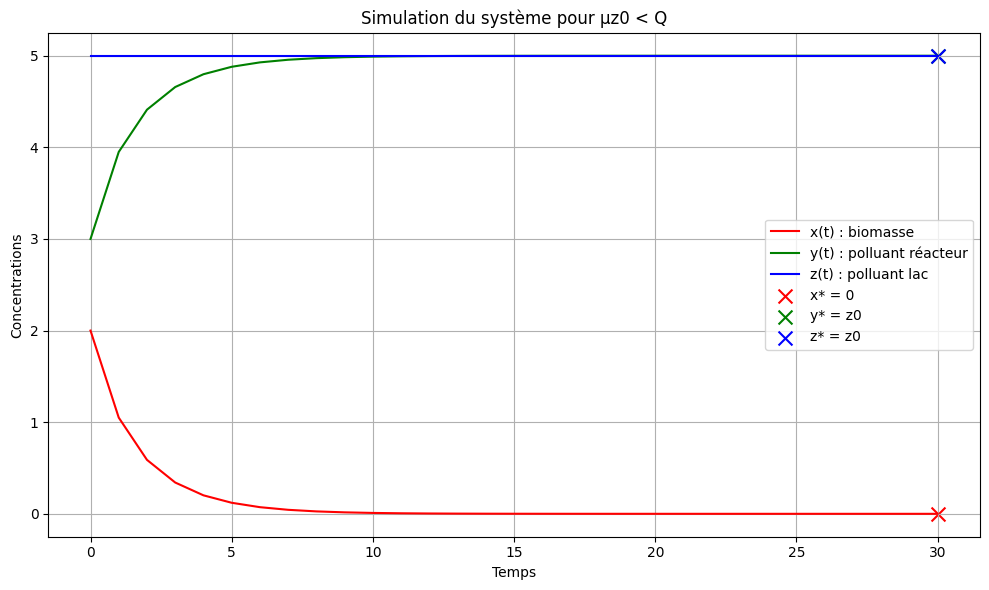

In [27]:
# === Paramètres du modèle === #
mu = 0.1
Q = 1
epsilon = 0

# === Paramètres de simulation === #
t_min = 0
t_max = 30
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0 , color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, z0, color='g', s = 100, marker='x', label = "y* = z0")
plt.scatter(t_max, z0, color='b', s = 100, marker='x', label = "z* = z0")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µz0 < Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point A est stable pour $\mu z_0 < Q$.

## Cas 2 : $\mu z_0 = Q$ -> test stabilité

point critique =  [0.01652895 4.98347105 5.        ]


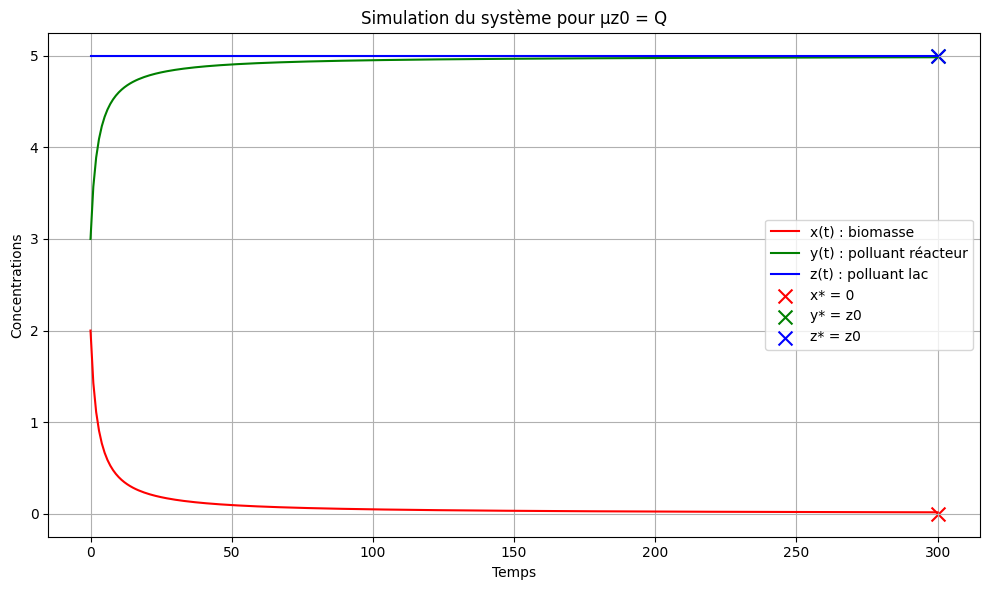

In [28]:
# === Paramètres du modèle === #
mu = 0.2
Q = 1
epsilon = 0

# === Paramètres de simulation === #
t_min = 0
t_max = 300
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0 , color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, z0, color='g', s = 100, marker='x', label = "y* = z0")
plt.scatter(t_max, z0, color='b', s = 100, marker='x', label = "z* = z0")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µz0 = Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point A est stable pour $\mu z_0 = Q$.

## Cas 3 : $\mu z_0 > Q$ -> test stabilité

point critique =  [2.99340887 2.00659113 5.        ]


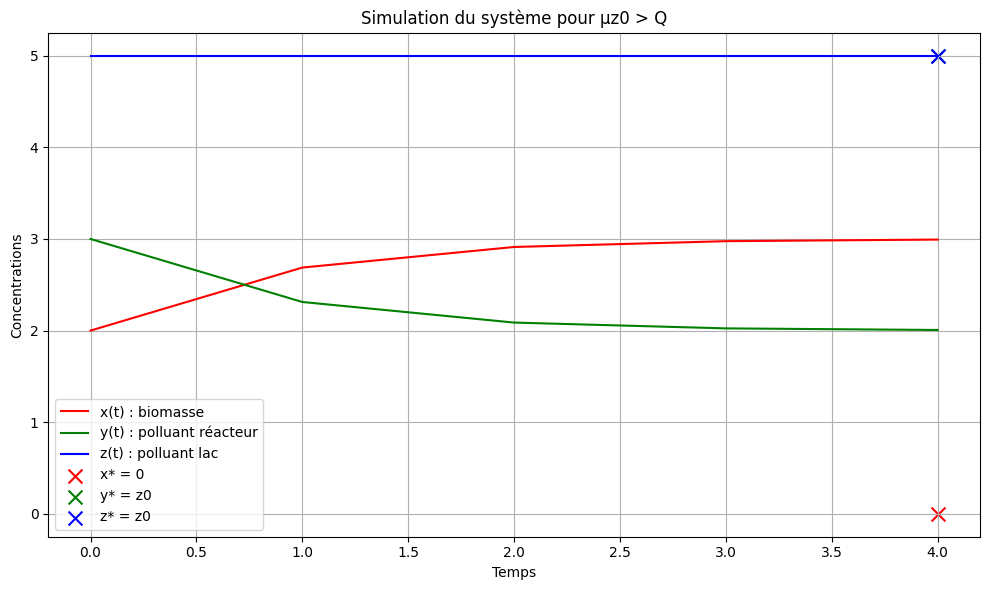

In [29]:
# === Paramètres du modèle === #
mu = 0.5
Q = 1
epsilon = 0

# === Paramètres de simulation === #
t_min = 0
t_max = 4
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0 , color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, z0, color='g', s = 100, marker='x', label = "y* = z0")
plt.scatter(t_max, z0, color='b', s = 100, marker='x', label = "z* = z0")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µz0 > Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point A n'est pas stable pour $\mu z_0 > Q$. Testons l'instabilité du point pour $\mu z_0 > Q$.

## Cas 3 : $\mu z_0 > Q$ -> test instabilité

point critique =  [0. 5. 5.]


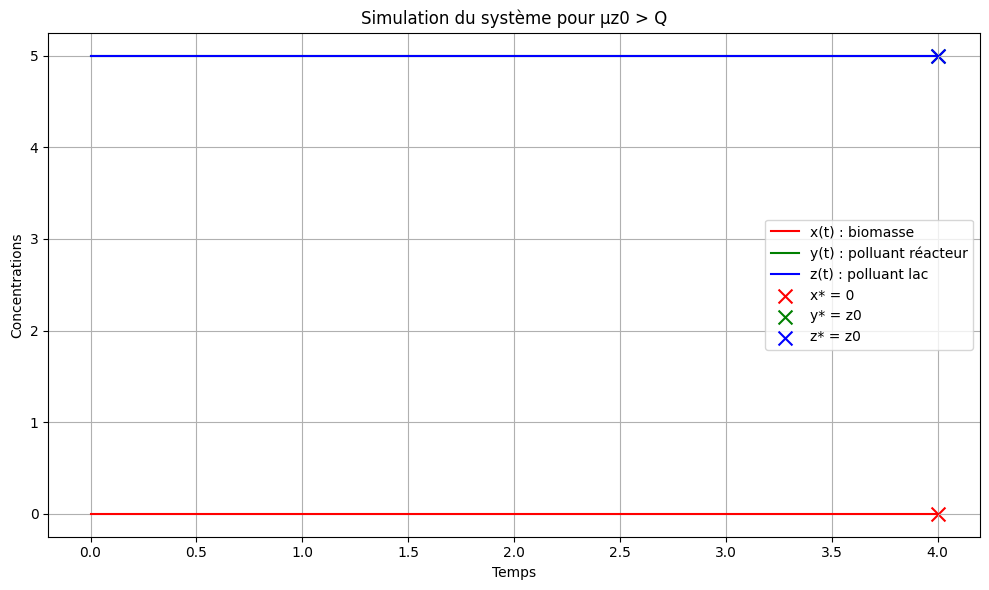

In [30]:
# === Paramètres du modèle === #
mu = 0.5
Q = 1
epsilon = 0

# === Paramètres de simulation === #
t_min = 0
t_max = 4
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 0
y0 = 5
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0 , color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, z0, color='g', s = 100, marker='x', label = "y* = z0")
plt.scatter(t_max, z0, color='b', s = 100, marker='x', label = "z* = z0")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µz0 > Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point A n'est pas non plus instable pour $\mu z_0 > Q$, il est donc marginal pour $\mu z_0 > Q$.

# Point critique 2 : $B = \begin{pmatrix} z0 - Q/\mu \\ Q/\mu \\ z0 \end{pmatrix} $

## Cas 1 : $\mu z_0 > Q$ -> test stabilité

point critique =  [2.99340887 2.00659113 5.        ]


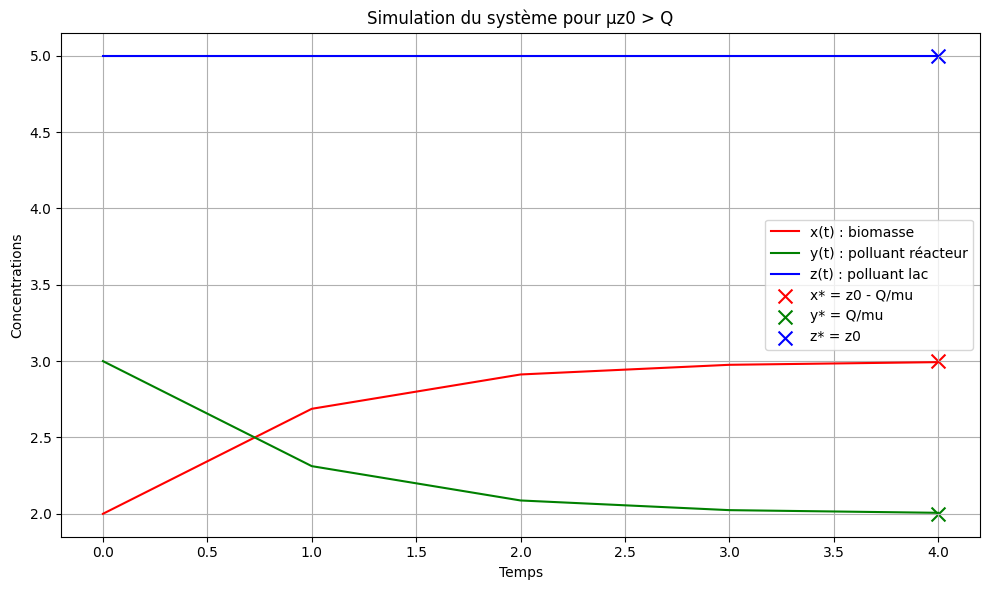

In [31]:
# === Paramètres du modèle === #
mu = 0.5
Q = 1
epsilon = 0

# === Paramètres de simulation === #
t_min = 0
t_max = 4
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, z0 - Q/mu , color='r', s = 100, marker='x', label = "x* = z0 - Q/mu")
plt.scatter(t_max, Q/mu, color='g', s = 100, marker='x', label = "y* = Q/mu")
plt.scatter(t_max, z0, color='b', s = 100, marker='x', label = "z* = z0")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µz0 > Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point B est stable pour $\mu z_0 > Q$.

## Cas 2 : $\mu z_0 = Q$ -> test stabilité

point critique =  [0.01652895 4.98347105 5.        ]


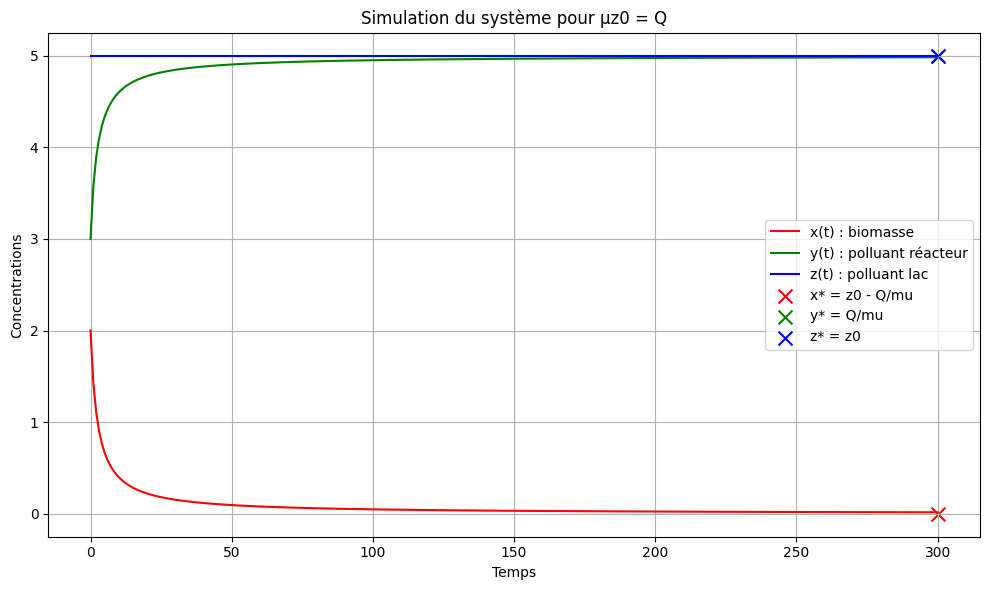

In [32]:
# === Paramètres du modèle === #
mu = 0.2
Q = 1
epsilon = 0

# === Paramètres de simulation === #
t_min = 0
t_max = 300
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, z0 - Q/mu , color='r', s = 100, marker='x', label = "x* = z0 - Q/mu")
plt.scatter(t_max, Q/mu, color='g', s = 100, marker='x', label = "y* = Q/mu")
plt.scatter(t_max, z0, color='b', s = 100, marker='x', label = "z* = z0")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µz0 = Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point B est stable pour $\mu z_0 = Q$.

# Cas $\epsilon > 0$

# Point critique : $C = \begin{pmatrix} 0 \\ y^* \\ y^* \end{pmatrix} $

## Cas 1 : $\mu y^* < Q$ -> test stabilité

point critique =  [1.97251273e-07 4.70002318e+00 4.70002334e+00]


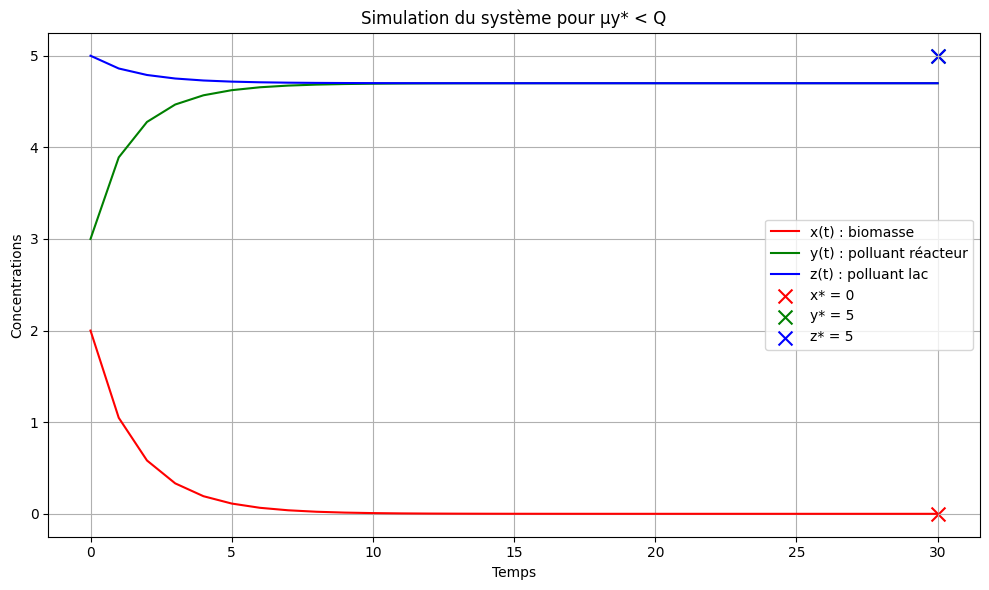

In [33]:
# === Paramètres du modèle === #
mu = 0.1
Q = 1
epsilon = 0.1

# === Paramètres de simulation === #
t_min = 0
t_max = 30
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0, color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, 5, color='g', s = 100, marker='x', label = "y* = 5")
plt.scatter(t_max, 5, color='b', s = 100, marker='x', label = "z* = 5")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µy* < Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point C est stable pour $\mu y^* < Q$. On a maintenant une valeur plus précise de $y^* = 4.7$.

## Cas 2 : $\mu y^* = Q$ -> test stabilité

point critique =  [0.01989418 4.08121233 4.09905175]


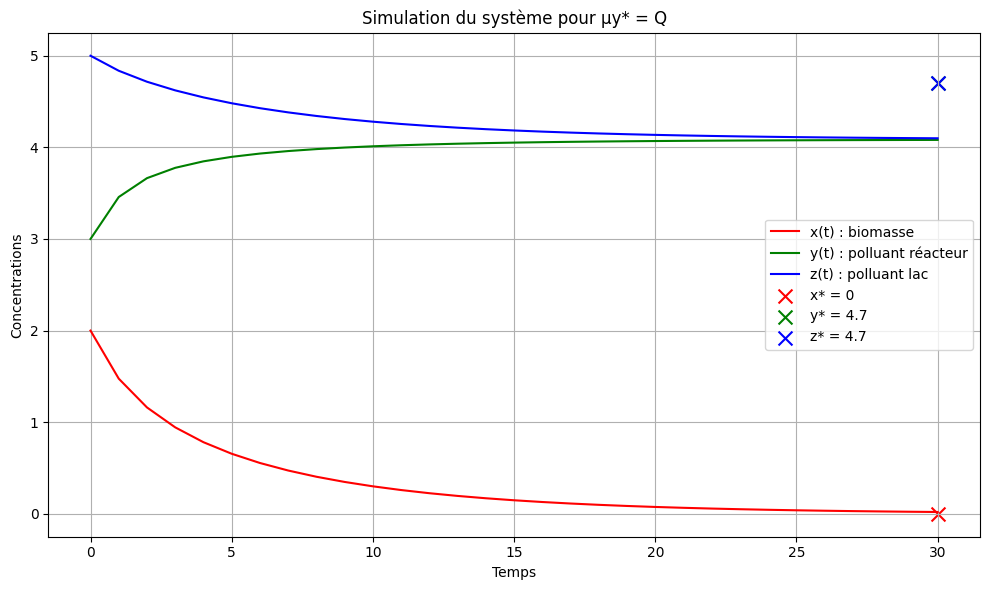

In [34]:
# === Paramètres du modèle === #
mu = 1/4.7
Q = 1
epsilon = 0.1

# === Paramètres de simulation === #
t_min = 0
t_max = 30
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution[t_max])

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0, color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, 4.7, color='g', s = 100, marker='x', label = "y* = 4.7")
plt.scatter(t_max, 4.7, color='b', s = 100, marker='x', label = "z* = 4.7")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µy* = Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point C est stable pour $\mu y^* = Q$, mais il tend vers un autre point $y^*$ que celui déterminé précédemment.

## Cas 3 : $\mu y^* > Q$ -> test stabilité

point critique =  [[ 2.00000000e+000  3.00000000e+000  5.00000000e+000]
 [ 2.62579519e+000  2.30737668e+000  4.74050570e+000]
 [-2.63070561e+000  7.39052007e+000  4.60162443e+000]
 [-1.67611485e+008  1.67611492e+008  4.82485646e+002]
 [-4.48744925e+128  4.48744925e+128  7.73515719e+062]
 [             nan              nan              nan]]


C:\Users\pmarg\AppData\Local\Temp\ipykernel_29904\3140580137.py:4: RuntimeWarning: overflow encountered in scalar multiply
  dx = mu * x * y - Q * x
C:\Users\pmarg\AppData\Local\Temp\ipykernel_29904\3140580137.py:5: RuntimeWarning: overflow encountered in scalar multiply
  dy = -mu * x * y + Q * (z - y)
C:\Users\pmarg\AppData\Local\Temp\ipykernel_29904\3140580137.py:4: RuntimeWarning: invalid value encountered in scalar subtract
  dx = mu * x * y - Q * x
C:\Users\pmarg\AppData\Local\Temp\ipykernel_29904\3140580137.py:5: RuntimeWarning: invalid value encountered in scalar add
  dy = -mu * x * y + Q * (z - y)


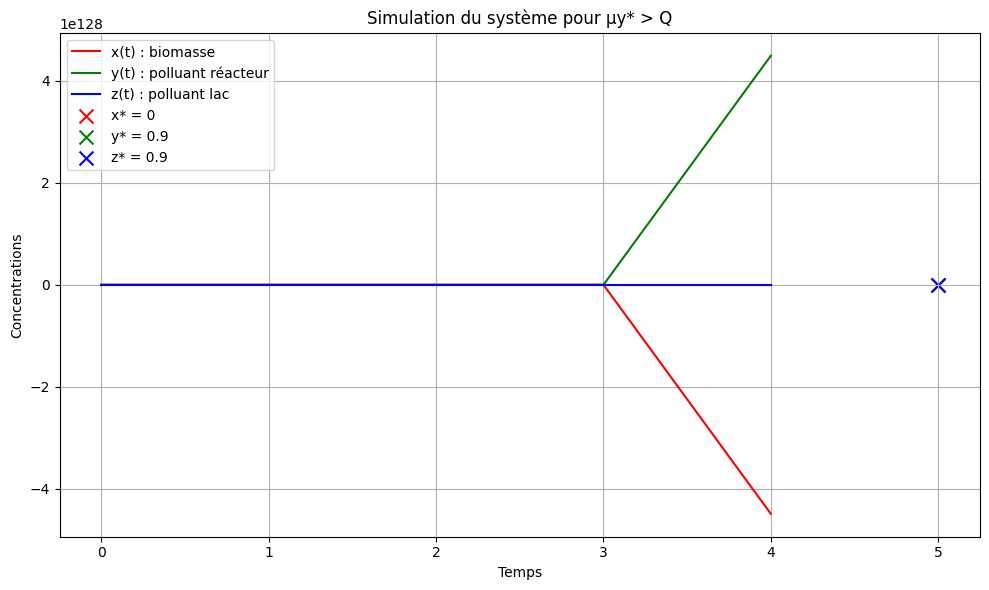

In [35]:
# === Paramètres du modèle === #
mu = 1.25
Q = 1
epsilon = 0.1

# === Paramètres de simulation === #
t_min = 0
t_max = 5
pas = 1
t = np.arange(start = t_min, stop = t_max + 1, step = pas)

# === Conditions initiales === #
x0 = 2
y0 = 3
z0 = 5
initial_state = np.array([x0, y0, z0])

# === Simulation === #
solution = rk4(system, initial_state, t)
print("point critique = ", solution)

# === Tracé des résultats === #
plt.figure(figsize=(10, 6))
# Courbes
plt.plot(t, solution[:, 0], "r", label = 'x(t) : biomasse')
plt.plot(t, solution[:, 1], "g", label = 'y(t) : polluant réacteur')
plt.plot(t, solution[:, 2], "b", label = 'z(t) : polluant lac')
# Point critique
plt.scatter(t_max, 0, color='r', s = 100, marker='x', label = "x* = 0")
plt.scatter(t_max, 0.9, color='g', s = 100, marker='x', label = "y* = 0.9")
plt.scatter(t_max, 0.9, color='b', s = 100, marker='x', label = "z* = 0.9")
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système pour µy* > Q')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le point C n'est pas stable pour $\mu y^* > Q$, il ets même instable car il diverge.

# Point critique : $D = \begin{pmatrix} 0 \\ Q/ \mu \\ Q/ \mu \end{pmatrix} $

## Test de la stabilité

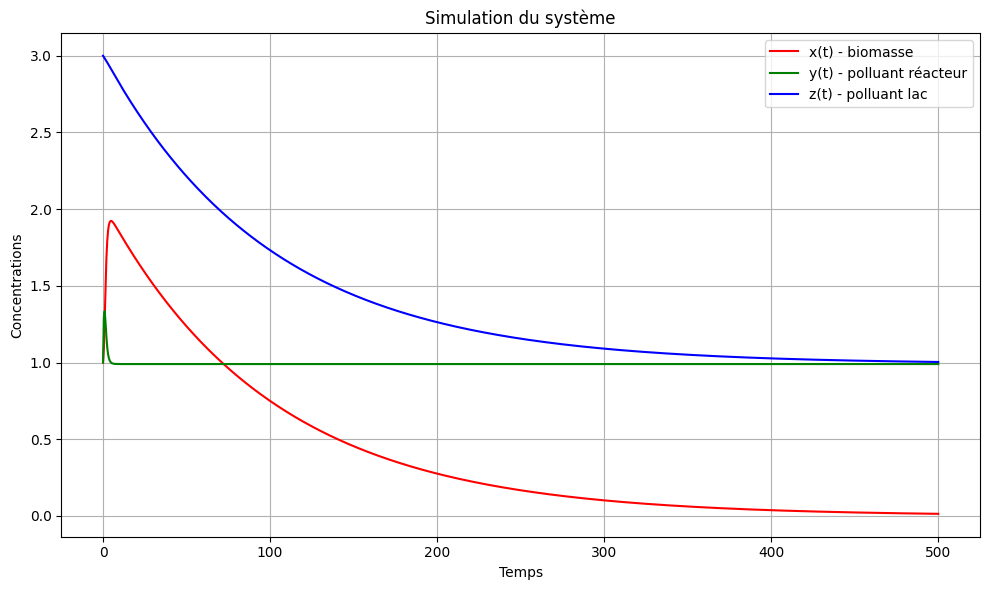

In [36]:
# === Paramètres du modèle ===
mu = 1.0
Q = 1.0
epsilon = 0.01

# === Paramètres de simulation ===
t_max = 500
n_points = 1000
t = np.linspace(0, t_max, n_points)

# === Conditions initiales ===
x0 = 1.0   # biomasse initiale
y0 = 1.0   # concentration polluant dans le réacteur
z0 = 3.0   # concentration dans le lac
initial_state = np.array([x0, y0, z0])

# Résoudre
solution = rk4(system, initial_state, t)

# === Tracé des résultats ===
plt.figure(figsize=(10, 6))
plt.plot(t, solution[:, 0], "r", label='x(t) - biomasse')
plt.plot(t, solution[:, 1], "g", label='y(t) - polluant réacteur')
plt.plot(t, solution[:, 2], "b",label='z(t) - polluant lac')
plt.xlabel('Temps')
plt.ylabel('Concentrations')
plt.title('Simulation du système')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

On remarque que nous avons bel est bien une convergence vers $Q/\mu$ pour y et z 

# Portrait de phase : 

### On peut voir un portrait de phase pour le cas epsilon = 0, et le point singulier  (0,z0,z0)

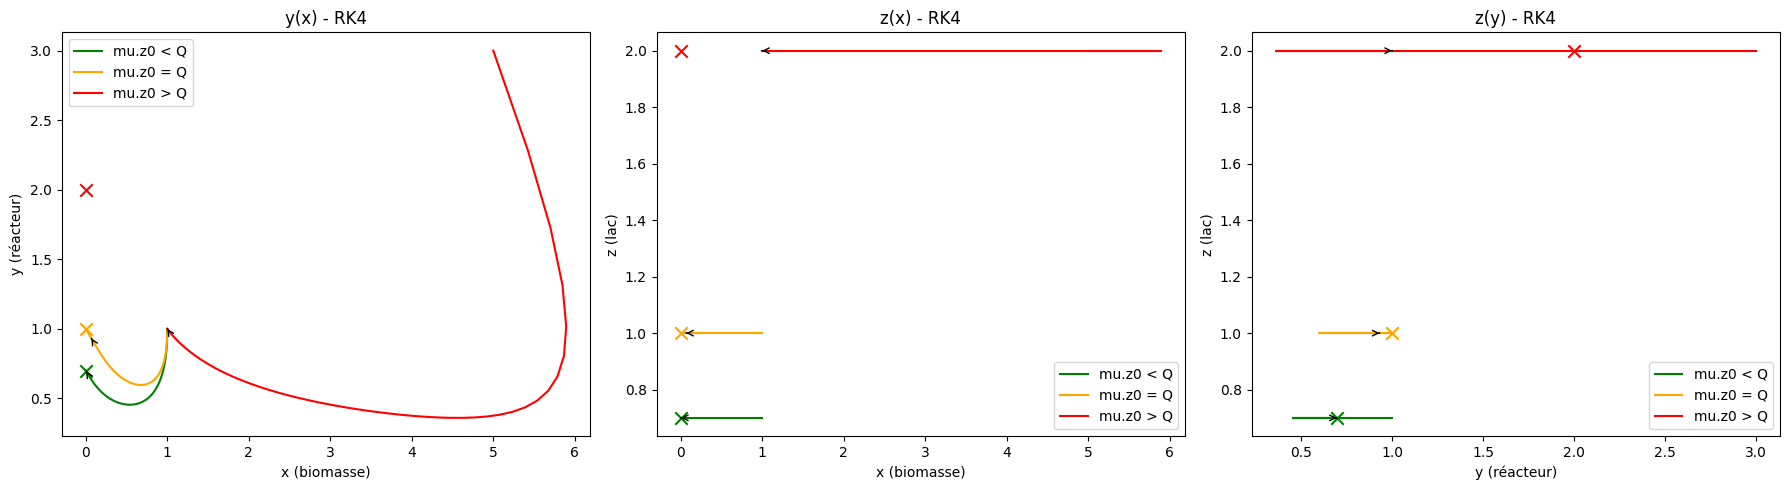

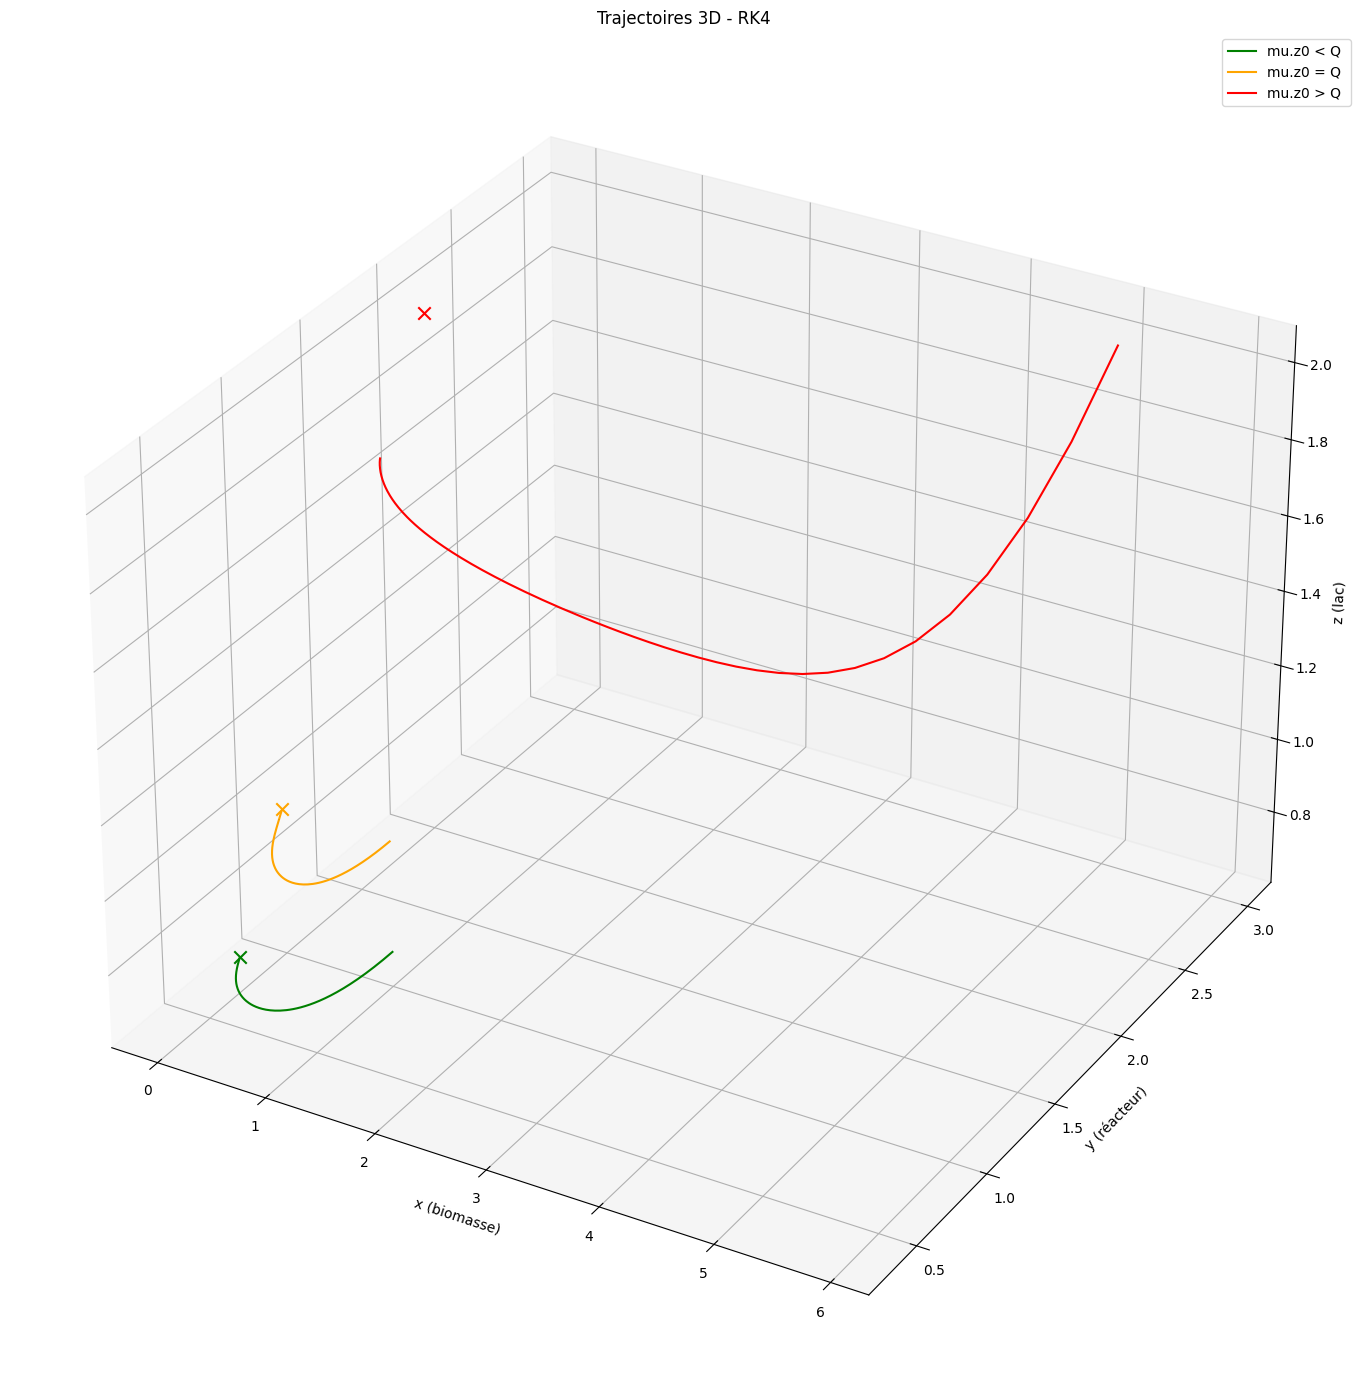

In [37]:
# === Paramètres ===
mu = 1.0
Q = 1.0
epsilon = 0
t = np.linspace(0, 50, 1000)
dt = t[1] - t[0]

# === Conditions initiales ===
init_stable = np.array([1.0, 1.0, 0.7])     # µz0 < Q
init_limite = np.array([1.0, 1.0, 1.0])     # µz0 = Q
init_pas_stable = np.array([5.0, 3.0, 2.0])   # µz0 > Q

pt_stable = point_critique_eps_egale_zero_B(init_stable[2])
pt_limite = point_critique_eps_egale_zero_B(init_limite[2])
pt_pas_stable = point_critique_eps_egale_zero_B(init_pas_stable[2])  

# === Simulation Euler explicite ===
sol_stable = rk4(system, init_stable, t)
sol_limite = rk4(system, init_limite, t)
sol_pas_stable = rk4(system, init_pas_stable, t)

# === Flèche directionnelle ===
i_arrow = 300

# === Projections 2D ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tracage_de_phase_stable_instable_limite(sol_stable,sol_limite,sol_pas_stable,"RK4")
trajectoire_3D_stable_instable_limite(sol_stable,sol_limite,sol_pas_stable,"RK4")

### Ici pour les cas epsilon > 0 et le point singulier (0,$Q/\mu,Q/\mu$)

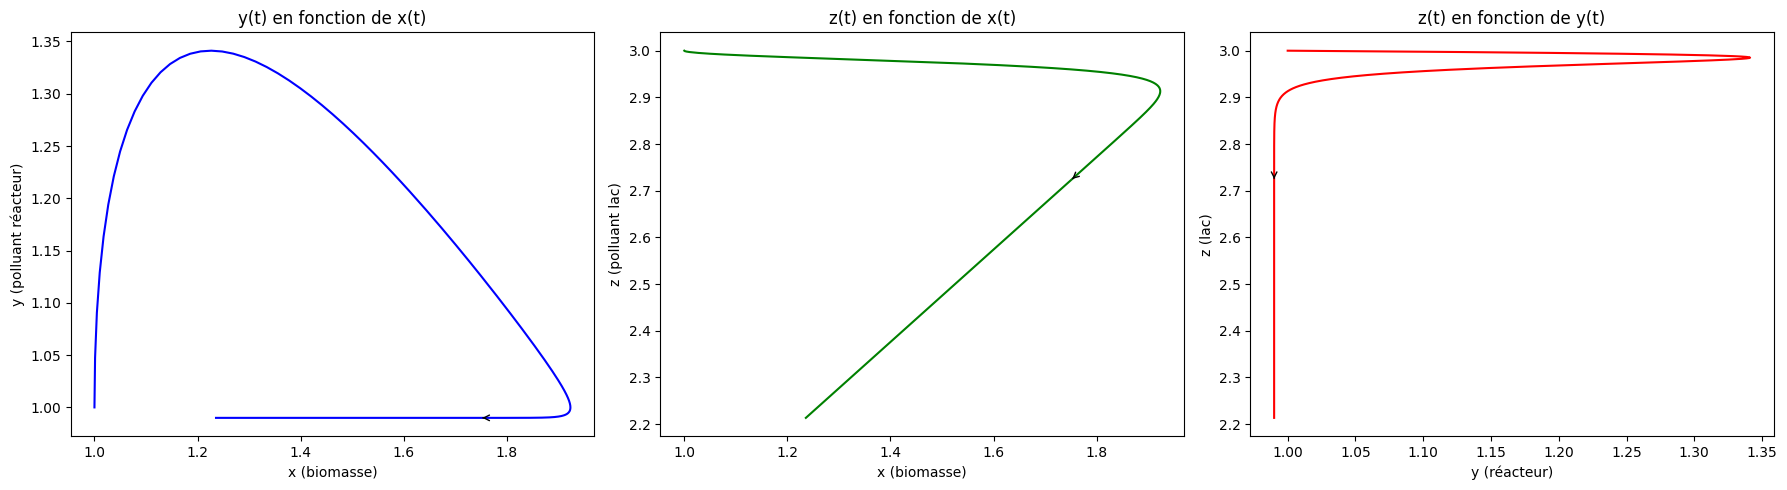

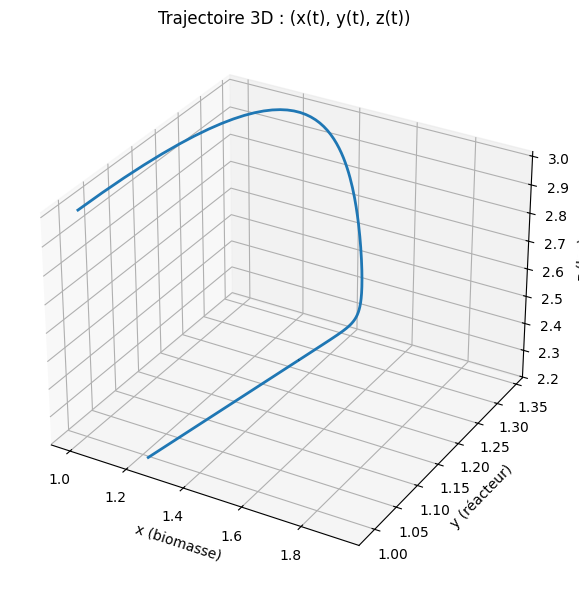

In [38]:
# === Paramètres du système ===
mu = 1.0
Q = 1.0
epsilon = 0.01

# === Conditions initiales ===
x0 = 1.0
y0 = 1.0
z0 = 3.0
initial_state = np.array([x0, y0, z0])

# === Simulation ===
t = np.linspace(0, 50, 1000)
solution = rk4(system, initial_state, t)
x, y, z = solution[:, 0], solution[:, 1], solution[:, 2] 

# === Projections 2D avec flèche ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# y vs x
axes[0].plot(x, y, color='blue')
axes[0].set_xlabel('x (biomasse)')
axes[0].set_ylabel('y (polluant réacteur)')
axes[0].set_title('y(t) en fonction de x(t)')
i = 300
axes[0].annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                 arrowprops=dict(arrowstyle="->", color='black'))

# z vs x
axes[1].plot(x, z, color='green')
axes[1].set_xlabel('x (biomasse)')
axes[1].set_ylabel('z (polluant lac)')
axes[1].set_title('z(t) en fonction de x(t)')
axes[1].annotate('', xy=(x[i+1], z[i+1]), xytext=(x[i], z[i]),
                 arrowprops=dict(arrowstyle="->", color='black'))

# z vs y
axes[2].plot(y, z, color='red')
axes[2].set_xlabel('y (réacteur)')
axes[2].set_ylabel('z (lac)')
axes[2].set_title('z(t) en fonction de y(t)')
axes[2].annotate('', xy=(y[i+1], z[i+1]), xytext=(y[i], z[i]),
                 arrowprops=dict(arrowstyle="->", color='black'))

plt.tight_layout()
plt.show()

# === 3D Trajectory with arrow ===
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=2)
ax.set_xlabel('x (biomasse)')
ax.set_ylabel('y (réacteur)')
ax.set_zlabel('z (lac)')
ax.set_title('Trajectoire 3D : (x(t), y(t), z(t))')

# Ajout de la flèche 3D
dx = x[i+1] - x[i]
dy = y[i+1] - y[i]
dz = z[i+1] - z[i]
ax.quiver(x[i], y[i], z[i], dx, dy, dz, color='black', arrow_length_ratio=0.1)

plt.tight_layout()
plt.show()


# Partie 2 : Dépollution du lac de la manière la plus optimale 

### On s'intéresse désormais à la dépollution la plus efficace du lac en jouant sur le débit Q, pour cela nous avons émis plusieurs hypothèses concernant notre système (cf rapport)

#### 1) Optimisation de Q, pour Q constant

In [39]:
mu = 1.0
epsilon = 0.01
z0 = 1.0
z1 = 0.2

# Fonction T(Q)
def T(Q):
    if Q <= 0 or Q >= mu * z1:
        return np.inf
    try:
        return -(1 / (epsilon * Q)) * np.log((z1 - Q / mu) / (z0 - Q / mu))
    except:
        return np.inf

# Trouver le minimum de T(Q)
result = minimize_scalar(T, bounds=(0.01, mu * z1 - 0.001), method='bounded')
Q_opt = result.x
T_opt = result.fun

print(f"Q optimal constant ≈ {Q_opt:.6f}")
print(f"T(Q_opt) ≈ {T_opt:.6f}")
print("On retrouve le Q constant optimal, renvoyant un temps minimum de dépollution. Donc au mieux, on pourra dépolluer le lac en 1889 jours")

Q optimal constant ≈ 0.150162
T(Q_opt) ≈ 1888.805422
On retrouve le Q constant optimal, renvoyant un temps minimum de dépollution. Donc au mieux, on pourra dépolluer le lac en 1889 jours


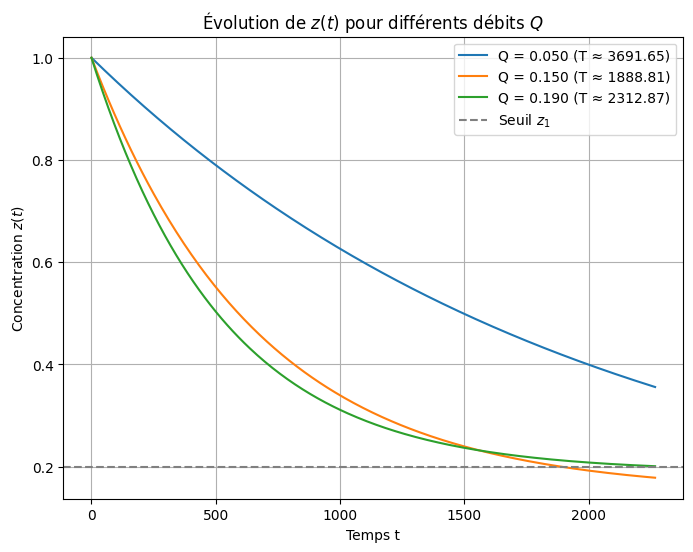

In [40]:
# Fonction z(t) pour un Q donné
def z_t(t, Q):
    return (Q / mu) + (z0 - Q / mu) * np.exp(-epsilon * Q * t)

# Tracé
t_vals = np.linspace(0, T_opt * 1.2, 300)
Q_values = [0.05, Q_opt, 0.19]  # Exemples de débits à comparer

plt.figure(figsize=(8,6))
for Q in Q_values:
    z_vals = z_t(t_vals, Q)
    label = f"Q = {Q:.3f} (T ≈ {T(Q):.2f})"
    plt.plot(t_vals, z_vals, label=label)

plt.axhline(z1, color='gray', linestyle='--', label='Seuil $z_1$')
plt.xlabel("Temps t")
plt.ylabel("Concentration $z(t)$")
plt.title("Évolution de $z(t)$ pour différents débits $Q$")
plt.legend()
plt.grid()
plt.show()


Confirmation de la convergence la plus rapide pour le meilleur débit constant retrouver, Q constant = 0.15

#### 2) Optimisation de Q, pour Q variant au cours du temps

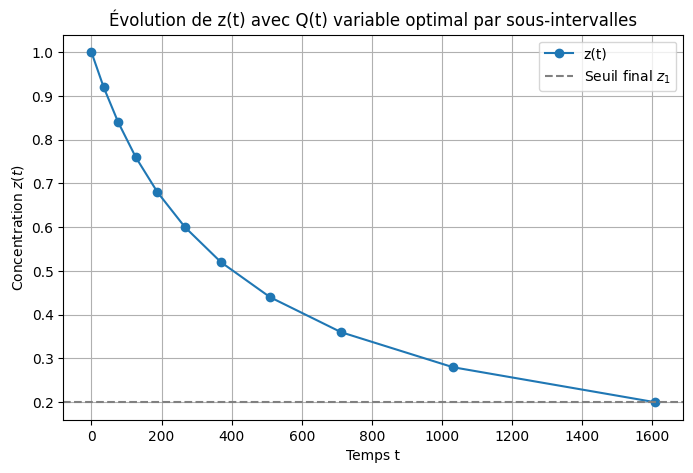

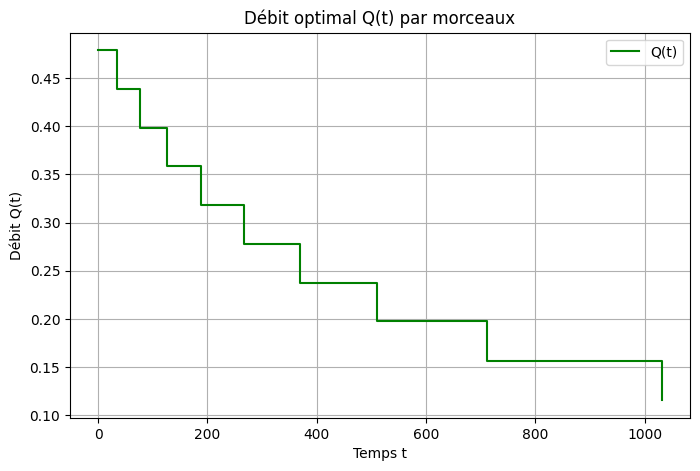

In [41]:
# Paramètres du modèle
mu = 1.0
epsilon = 0.01
z0 = 1.0
z1 = 0.2
N = 10  # Nombre d'intervalles de contrôle

# Génération des seuils intermédiaires y_i
y_vals = np.linspace(z0, z1, N + 1)  # y0, y1, ..., yN = z1

# Fonction y_inf(Q) = Q / mu
def y_inf(Q):
    return Q / mu

# Temps nécessaire pour passer de yi à yi+1 à débit Q
def T_step(Q, yi, yi1):
    yinf = y_inf(Q)
    num = yi - yinf
    den = yi1 - yinf
    if Q <= 0 or den <= 0 or num <= 0:
        return np.inf
    try:
        return -(1 / (epsilon * Q)) * np.log(den / num)
    except:
        return np.inf

# Initialisation des résultats
Q_list = []
T_list = []
z_list = [z0]
t_list = [0]

# Optimisation sur chaque intervalle [yi, yi+1]
for i in range(N):
    yi = y_vals[i]
    yi1 = y_vals[i + 1]

    # Trouver le Q_i qui minimise T_step
    result = minimize_scalar(lambda Q: T_step(Q, yi, yi1), bounds=(1e-3, mu * yi1 - 1e-6), method='bounded')
    Q_opt = result.x
    T_opt = T_step(Q_opt, yi, yi1)

    # Stockage
    Q_list.append(Q_opt)
    T_list.append(T_opt)
    t_list.append(t_list[-1] + T_opt)
    z_list.append(yi1)

# Conversion en arrays
t_array = np.array(t_list)
z_array = np.array(z_list)
Q_array = np.array(Q_list)

# Tracé de z(t)
plt.figure(figsize=(8,5))
plt.plot(t_array, z_array, marker='o', label='z(t)')
plt.axhline(z1, color='gray', linestyle='--', label='Seuil final $z_1$')
plt.xlabel("Temps t")
plt.ylabel("Concentration $z(t)$")
plt.title("Évolution de z(t) avec Q(t) variable optimal par sous-intervalles")
plt.grid()
plt.legend()
plt.show()

# Tracé de Q(t)
plt.figure(figsize=(8,5))
plt.step(t_array[:-1], Q_array, where='post', label='Q(t)', color='green')
plt.xlabel("Temps t")
plt.ylabel("Débit Q(t)")
plt.title("Débit optimal Q(t) par morceaux")
plt.grid()
plt.legend()
plt.show()


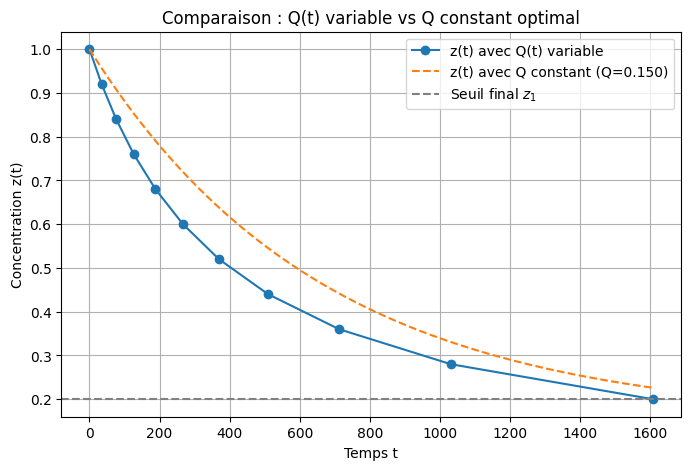

In [42]:
# Fonction z(t) pour Q constant optimal
def z_t_constant(t, Q, z_init=z0):
    yinf = Q / mu
    return yinf + (z_init - yinf) * np.exp(-epsilon * Q * t)

# Fonction T_global(Q) = temps total pour passer de z0 à z1 avec Q constant
def T_global(Q):
    yinf = Q / mu
    if Q <= 0 or yinf >= z0 or yinf >= z1:
        return np.inf
    try:
        return -(1 / (epsilon * Q)) * np.log((z1 - yinf) / (z0 - yinf))
    except:
        return np.inf

# Trouver le Q optimal global pour débit constant
res_cte = minimize_scalar(T_global, bounds=(1e-3, mu * z1 - 1e-6), method='bounded')
Q_cte = res_cte.x
T_cte = T_global(Q_cte)


# Tracer z(t) avec Q constant optimal
t_fine = np.linspace(0, t_array[-1], 300)  # même durée que pour le Q variable
z_cte_vals = z_t_constant(t_fine, Q_cte)

# Superposition sur le même graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(t_array, z_array, marker='o', label='z(t) avec Q(t) variable')
plt.plot(t_fine, z_cte_vals, linestyle='--', label=f'z(t) avec Q constant (Q={Q_cte:.3f})')
plt.axhline(z1, color='gray', linestyle='--', label='Seuil final $z_1$')
plt.xlabel("Temps t")
plt.ylabel("Concentration z(t)")
plt.title("Comparaison : Q(t) variable vs Q constant optimal")
plt.grid()
plt.legend()
plt.show()

# Comparaison aux autres méthodes numériques 

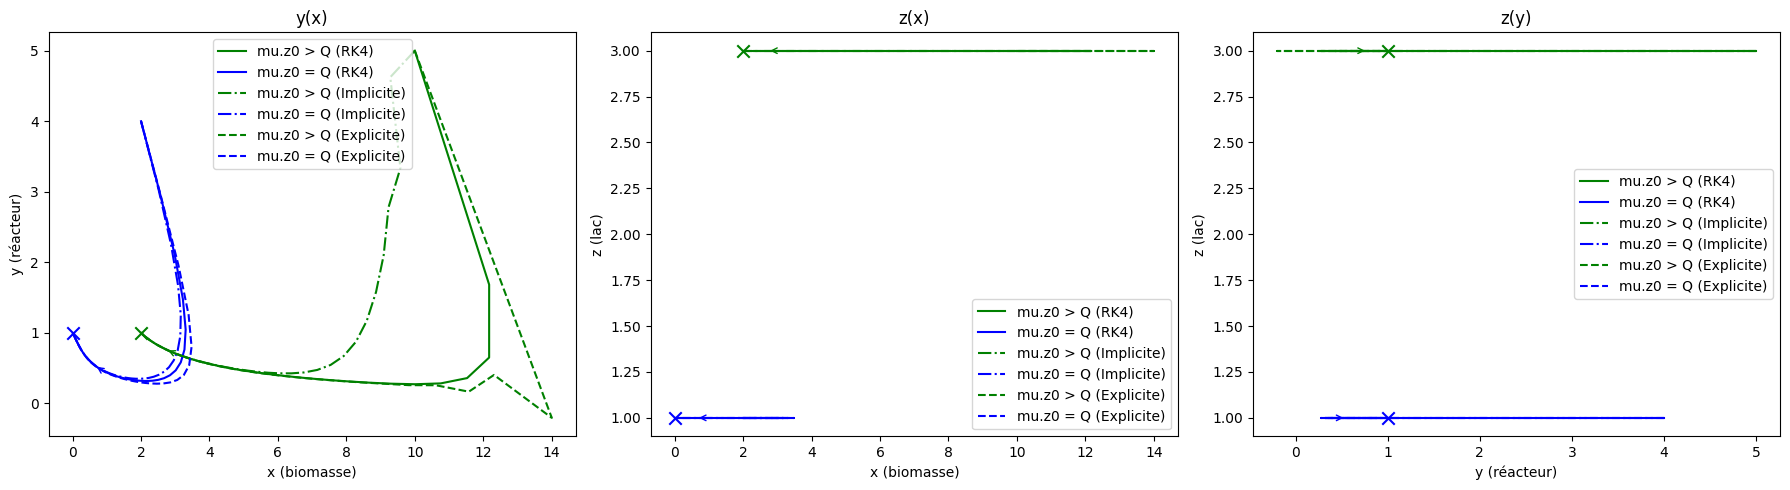

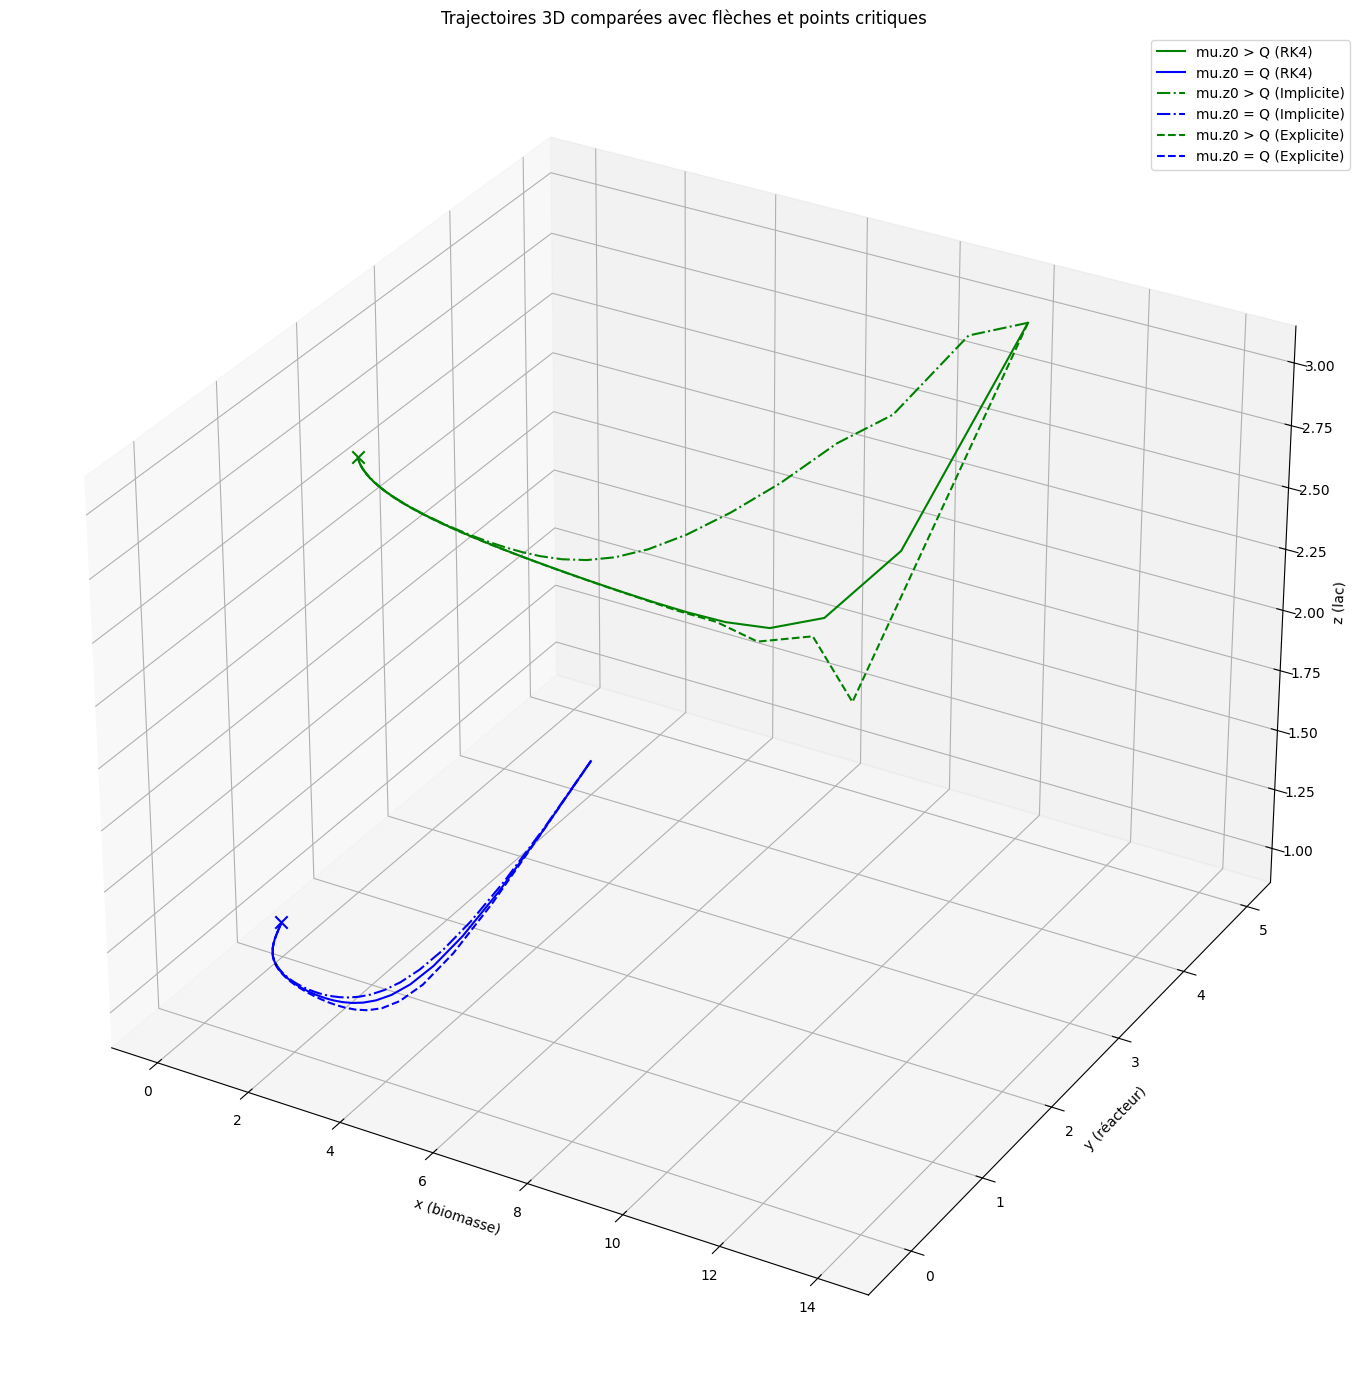

In [43]:
# === Paramètres ===
mu = 1.0
Q = 1.0
epsilon = 0
t = np.linspace(0, 100, 1000)
dt = t[1] - t[0]

# === Conditions initiales ===
init_stable = np.array([10.0, 5.0, 3.0])     # µz > Q
init_limite = np.array([2, 4.0, 1.0])     # µz = Q

# === Système différentiel ===
sol_stable_explicite = euler_explicit(system, init_stable, t)
sol_limite_explicite = euler_explicit(system, init_limite, t)
sol_stable_rk4 = rk4(system, init_stable, t)
sol_limite_rk4 = rk4(system, init_limite, t)
sol_stable_implicite = euler_implicit(system, init_stable, t)
sol_limite_implicite = euler_implicit(system, init_limite, t)


#Point Critique
pt_stable = point_critique_eps_egale_zero_A(mu, Q, init_stable[2])
pt_limite = point_critique_eps_egale_zero_A(mu, Q, init_limite[2])

i_arrow = 30  # index pour position de la flèche

# === Projections 2D ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Configuration pour les 3 graphes
plot_configs = [
    {'x_idx': 0, 'y_idx': 1, 'xlabel': 'x (biomasse)', 'ylabel': 'y (réacteur)', 'title': 'y(x)'},
    {'x_idx': 0, 'y_idx': 2, 'xlabel': 'x (biomasse)', 'ylabel': 'z (lac)', 'title': 'z(x)'},
    {'x_idx': 1, 'y_idx': 2, 'xlabel': 'y (réacteur)', 'ylabel': 'z (lac)', 'title': 'z(y)'}
]
# Toutes les solutions et leurs styles associés
solutions = [
    (sol_stable_rk4, 'green', '-', 'mu.z0 > Q (RK4)'),
    (sol_limite_rk4, 'blue', '-', 'mu.z0 = Q (RK4)'),
    (sol_stable_implicite, 'green', '-.', 'mu.z0 > Q (Implicite)'),
    (sol_limite_implicite, 'blue', '-.', 'mu.z0 = Q (Implicite)'),
    (sol_stable_explicite, 'green', '--', 'mu.z0 > Q (Explicite)'),
    (sol_limite_explicite, 'blue', '--', 'mu.z0 = Q (Explicite)'),
   
]
# Points spéciaux à scatter
scatter_points = [
    (pt_stable, 'green'),
    (pt_limite, 'blue'),
]
# Boucle principale sur les axes
for idx, config in enumerate(plot_configs):
    ax = axes[idx]
    for sol, color, linestyle, label in solutions:
        ax.plot(sol[:, config['x_idx']], sol[:, config['y_idx']], linestyle, color=color, label=label)
        # Flèche pour RK4 uniquement
        if 'RK4' in label:
            ax.annotate('', 
                        xy=(sol[i_arrow+1, config['x_idx']], sol[i_arrow+1, config['y_idx']]),
                        xytext=(sol[i_arrow, config['x_idx']], sol[i_arrow, config['y_idx']]),
                        arrowprops=dict(arrowstyle="->", color=color))
    # Scatter points
    for pt, color in scatter_points:
        ax.scatter(pt[config['x_idx']], pt[config['y_idx']], color=color, marker='x', s=80)

    # Labels et titre
    ax.set_xlabel(config['xlabel'])
    ax.set_ylabel(config['ylabel'])
    ax.set_title(config['title'])
    ax.legend()
plt.tight_layout()
plt.show()

# === Trajectoire 3D ===
fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol_stable_rk4[:, 0], sol_stable_rk4[:, 1], sol_stable_rk4[:, 2], label='mu.z0 > Q (RK4)', linestyle = '-', color='green')
ax.plot(sol_limite_rk4[:, 0], sol_limite_rk4[:, 1], sol_limite_rk4[:, 2], label='mu.z0 = Q (RK4)', linestyle = '-', color='blue')
ax.plot(sol_stable_implicite[:, 0], sol_stable_implicite[:, 1], sol_stable_implicite[:, 2], label='mu.z0 > Q (Implicite)', linestyle = '-.', color='green')
ax.plot(sol_limite_implicite[:, 0], sol_limite_implicite[:, 1], sol_limite_implicite[:, 2], label='mu.z0 = Q (Implicite)', linestyle = '-.', color='blue')
ax.plot(sol_stable_explicite[:, 0], sol_stable_explicite[:, 1], sol_stable_explicite[:, 2], label='mu.z0 > Q (Explicite)', linestyle = '--', color='green')
ax.plot(sol_limite_explicite[:, 0], sol_limite_explicite[:, 1], sol_limite_explicite[:, 2], label='mu.z0 = Q (Explicite)', linestyle = '--', color='blue')

# Points critiques
ax.scatter(*pt_stable, color='green', marker='x', s=80)
ax.scatter(*pt_limite, color='blue', marker='x', s=80)

# Flèche 3D sur cas limite
dx = sol_limite_rk4[i_arrow+1, 0] - sol_limite_rk4[i_arrow, 0]
dy = sol_limite_rk4[i_arrow+1, 1] - sol_limite_rk4[i_arrow, 1]
dz = sol_limite_rk4[i_arrow+1, 2] - sol_limite_rk4[i_arrow, 2]
ax.quiver(sol_limite_rk4[i_arrow, 0], sol_limite_rk4[i_arrow, 1], sol_limite_rk4[i_arrow, 2],
          dx, dy, dz, color='black', arrow_length_ratio=0.1)

ax.set_xlabel('x (biomasse)')
ax.set_ylabel('y (réacteur)')
ax.set_zlabel('z (lac)')
ax.set_title('Trajectoires 3D comparées avec flèches et points critiques')
ax.legend()
plt.tight_layout()
plt.show()



#### On constate que les méthodes sont bel est bien assez similaire, on note aussi que l'on peut voir le phénomène de gain et de pertes "d'énergies" de Euler Explcite et Implicite

# Ordre de convergence des méthodes numériques

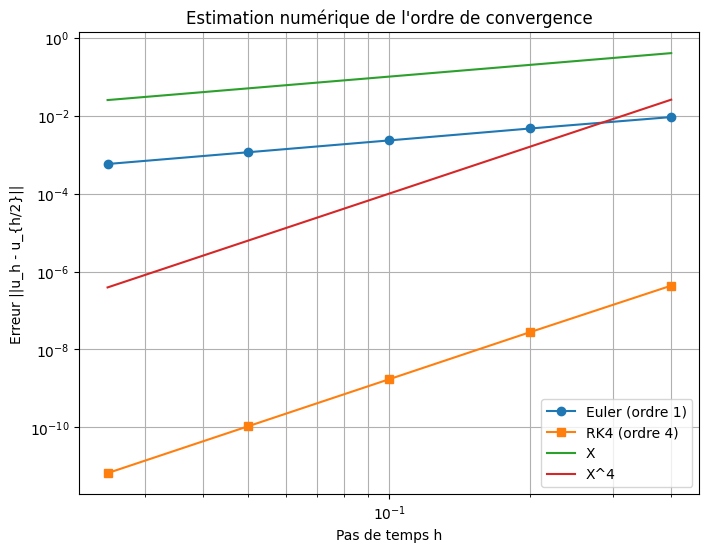

In [44]:
# Paramètres du modèle
mu = 1.0
epsilon = 0.01
z0_init = 1.0
y0_init = 0.0
x0_init = 0.1
tf = 5.0
Q = 0.1
u0 = np.array([x0_init, y0_init, z0_init])

# Euler explicite (avec maillage correct)
def euler_system(system, u0, h, tf):
    N = int(tf / h)
    t = np.linspace(0, N * h, N + 1)
    u = np.zeros((N + 1, len(u0)))
    u[0] = u0
    for n in range(N):
        u[n + 1] = u[n] + h * system(t[n], u[n])
    return t, u

# RK4 explicite
def rk4_system(system, u0, h, tf):
    N = int(tf / h)
    t = np.linspace(0, N * h, N + 1)
    u = np.zeros((N + 1, len(u0)))
    u[0] = u0
    for n in range(N):
        k1 = system(t[n], u[n])
        k2 = system(t[n] + h/2, u[n] + h/2 * k1)
        k3 = system(t[n] + h/2, u[n] + h/2 * k2)
        k4 = system(t[n] + h, u[n] + h * k3)
        u[n+1] = u[n] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return t, u

# Comparaison entre pas h et h/2
def compare_h_h2(method_solver, h, tf):
    t_h, u_h = method_solver(system, u0, h, tf)
    t_h2, u_h2 = method_solver(system, u0, h/2, tf)
    u_h2_interp = u_h2[::2]  # Sous-échantillonnage
    error = np.linalg.norm(u_h - u_h2_interp, ord=np.inf)
    return error

# Listes des pas de temps
h_list = [0.4, 0.2, 0.1, 0.05, 0.025]
errors_euler = []
errors_rk4 = []

for h in h_list:
    errors_euler.append(compare_h_h2(euler_system, h, tf))
    errors_rk4.append(compare_h_h2(rk4_system, h, tf))

# Affichage du graphe log-log
plt.figure(figsize=(8,6))
plt.loglog(h_list, errors_euler, 'o-', label='Euler (ordre 1)')
plt.loglog(h_list, errors_rk4, 's-', label='RK4 (ordre 4)')
X = np.linspace(0.025,0.4,1000)
plt.loglog(X, X, label='X')
plt.loglog(X, X**4, label='X^4')

plt.xlabel("Pas de temps h")
plt.ylabel("Erreur ||u_h - u_{h/2}||")
plt.title("Estimation numérique de l'ordre de convergence")
plt.grid(which="both")
plt.legend()
plt.show()


On a tracé les courbes de pente 1 et 4. On constate que les méthodes d'Euler sont d'ordre 1, et celle de rk4 d'ordre 4. Cela confirme la meilleur précision du schéma numérique de rk4 sur celle des méthodes d'Euler explicite et implicite.

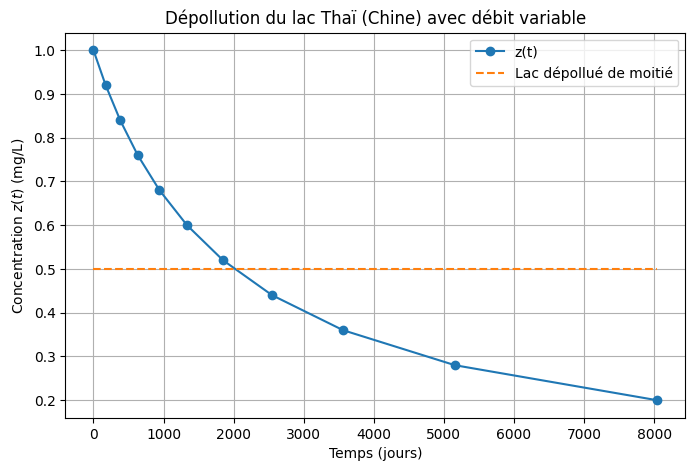

In [45]:
# Paramètres du modèle
mu = 20
VR = 4.5e5 # 50 * 100 * 90
VL = 4.5e9
epsilon = VR/VL
z0 = 1.0
z1 = 0.2
N = 10  # Nombre d'intervalles de contrôle

# Génération des seuils intermédiaires y_i
y_vals = np.linspace(z0, z1, N + 1)  # y0, y1, ..., yN = z1

# Initialisation des résultats
Q_list = []
T_list = []
z_list = [z0]
t_list = [0]

# Optimisation sur chaque intervalle [yi, yi+1]
for i in range(N):
    yi = y_vals[i]
    yi1 = y_vals[i + 1]

    # Trouver le Q_i qui minimise T_step
    result = minimize_scalar(lambda Q: T_step(Q, yi, yi1), bounds=(1e-3, mu * yi1 - 1e-6), method='bounded')
    Q_opt = result.x
    T_opt = T_step(Q_opt, yi, yi1)

    # Stockage
    Q_list.append(Q_opt)
    T_list.append(T_opt)
    t_list.append(t_list[-1] + T_opt)
    z_list.append(yi1)

# Conversion en arrays
t_array = np.array(t_list)
z_array = np.array(z_list)
Q_array = np.array(Q_list)

# Tracé de z(t)
plt.figure(figsize=(8,5))
plt.plot(t_array, z_array, marker='o', label='z(t)')
plt.plot(t_array, t_array*0 + 0.5, '--', label = 'Lac dépollué de moitié')
plt.xlabel("Temps (jours)")
plt.ylabel("Concentration $z(t)$ (mg/L)")
plt.title("Dépollution du lac Thaï (Chine) avec débit variable")
plt.grid()
plt.legend()
plt.show()

On prouve que pour Q dépendant de t, on a une convergence plus rapide que pour Q constant